# M12e: Coupled pendulums and degree of coupling

by:

- Fatemeh karimi Barikarasfi (3765009)
- Souvik Mukherjee (3780278)

# Introduction

In this experiment, the dynamics of a set of coupled pendulums were investigated in order to study how mechanical coupling influences oscillatory motion. When two identical pendulums are connected by a coupling spring, their interaction gives rise to distinct modes of oscillation namely the in-phase and out-of-phase normal modes as well as the phenomenon of beats. By systematically varying the position of the coupling spring, we measured the corresponding oscillation periods of these modes and the resulting beat period to quantify the strength of coupling between the pendulums. Using these measurements, the beat period was compared with theoretical predictions, the degree of coupling was determined, and the influence of spring position on the oscillation behavior was analyzed.

# Experimental Setup

For this experiment, two metal rods were used as the pendulums, with holes in each to allow for a spring to be attached between them. These rods were each connected to a potentiometer, which were in turn connected to a laptop, to allow for computerized data collection of the amplitude of the oscillations. On the laptop the PACs software was used, which allowed for setting the data acquisition period and exporting said data as ASCII Format. 

For this experiment, a spring of the following characteristics was used. All values were provided on the spring box.

| Constant | Value |
|:--------:|:--------:|
|  Length   |  14.75 cm   |
|  Spring Diameter   |  7.75 mm   |
|  Mass   |  8.393 g   |
|  Number of Windings   |  368   |
|  Wire Diameter   |  0.400 mm   |

The metal pendulums had the following characteristics. Positions 3,4 and 5 were used for this experiment. The masses of the pendulums were 1.329 kg and 1.330 kg respectively, and the distance of the center of gravity to the rotation axis $S_a$ was 0.747 m for both pendulums

| Spring Position | Distance from Spring Position to Rotation Axis(m) |
|:--------:|:--------:|
|  1   |  0.282   |
|  2   |  0.382   |
|  3   |  0.482   |
|  4   |  0.582   |
|  5   |  0.682   |
|  6   |  0.782   |
|  7   |  0.882   |
|  8   |  1.022   |

Finally, data acquisition time for all experiments was set at 10 seconds as this provided a balance between detail and a reasonable sample size. For the beat phase experiments however, the acquisition time was set at 60 seconds to allow for proper capture of the entire beat. 

# Theoretical Background

As shown in the lab manual, when both the pendulums are initialized with the same amplitude $\varphi_0$ and in the same direction, they oscillate in-phase. When they are started with the same amplitude, with the EOMs:

\begin{equation}
    \varphi_1 = \varphi_2 = \varphi_0 \:cos(\omega_1t)
\end{equation}

But when initialized with the same amplitude $\phi_0$ in the opposite direction, they oscillate out-of-phase, with the EOMs:

\begin{equation}
    \varphi_1 = - \varphi_2 = \varphi_0 \:cos(\omega_2t)
\end{equation}

However, when one pendulum is kept at amplitude $0$, and the other pendulum is initialized with the amplitude $\psi_0$, we get a beat behavior, with EOMs:
\begin{equation}
    \varphi_1 = \varphi_{0} \sin\left[\frac{1}{2}(\omega_{2}-\omega_{1})t\right] 
\sin\left[\frac{1}{2}(\omega_{2}+\omega_{1})t\right]
\end{equation}

\begin{equation}
    \varphi_2 = \varphi_{0} \cos\left[\frac{1}{2}(\omega_{2}-\omega_{1})t\right] 
\cos\left[\frac{1}{2}(\omega_{2}+\omega_{1})t\right]
\end{equation}

For weak coupling, we then get an oscillation with the angular frequency:

\begin{equation}
    \omega = \frac{\omega_{1} + \omega_{2}}{2}
\end{equation}

And this oscillation is modulated by a beat frequency $\omega_s$:
\begin{equation}
    \omega_{s} = \omega_{2} - \omega_{1}
\end{equation}

Therefore, we can get the corresponding periods:
\begin{equation}
    \frac{1}{T} = \frac{1}{2}\left(\frac{1}{T_2}+\frac{1}{T_1}\right)
\end{equation}

\begin{equation}
    \frac{1}{T_S} = \frac{1}{T_2} - \frac{1}{T_1}
\end{equation}

Using the definition of the degree of coupling, we get:
\begin{equation}
    k = \frac{T_1^2 - T_2^2}{T_1^2 + T_2^2}
\end{equation}

For Task 3, we need to derive an equation for the degree of coupling that uses $T$ and $T_S$. We can express
\begin{equation}
\omega_1 = \omega - \frac{\omega_s}{2}, \qquad 
\omega_2 = \omega + \frac{\omega_s}{2}.
\end{equation}

The degree of coupling is defined as
\begin{equation}
k = \frac{\omega_2^2 - \omega_1^2}{\omega_2^2 + \omega_1^2}.
\end{equation}

Using the identity $(\omega_2^2 - \omega_1^2) = (\omega_2 - \omega_1)(\omega_2 + \omega_1)$, we obtain
\begin{equation}
k = \frac{(\omega_2 - \omega_1)(\omega_2 + \omega_1)}{\omega_2^2 + \omega_1^2}
= \frac{2\omega \, \omega_s}{\omega_1^2 + \omega_2^2}.
\end{equation}

Next, compute the denominator:
\begin{equation}
\omega_1^2 + \omega_2^2 
= \left( \omega - \frac{\omega_s}{2} \right)^2 + \left( \omega + \frac{\omega_s}{2} \right)^2
= 2\omega^2 + \frac{1}{2}\omega_s^2
= \frac{4\omega^2 + \omega_s^2}{2}.
\end{equation}

Thus,
\begin{equation}
k = \frac{2\omega \, \omega_s}{\frac{4\omega^2 + \omega_s^2}{2}}
= \frac{4\omega \, \omega_s}{4\omega^2 + \omega_s^2}.
\end{equation}

Substituting $\omega = \frac{2\pi}{T}$ and $\omega_s = \dfrac{2\pi}{T_s}$, the factors of $2\pi$ cancel, giving
\begin{equation}
k = \frac{4 T T_s}{T^2 + 4 T_s^2}.
\end{equation}

Finally, for Task 4, we have to derive the equation $\frac{T_{1}^{2}}{T_{2}^{2}}=1+2\frac{D^{*}}{D}$,

For small oscillations each uncoupled pendulum satisfies
\begin{equation}
I\ddot{\varphi} + D\varphi = 0,
\end{equation}

so the natural (in-phase) angular frequency is

\begin{equation}
\omega_{1}^{2}=\frac{D}{I}.
\end{equation}

For the out-of-phase mode the coupling spring produces an additional restoring torque.
If the spring's torque constant is $D^{*}$ then each pendulum experiences an extra torque $D^{*}\varphi$ and because the two pendula move oppositely the total additional torque acting on the relative coordinate is $2D^{*}\varphi$. Hence the equation of motion becomes
\begin{equation}
I\ddot{\varphi} + (D+2D^{*})\varphi = 0,
\end{equation}
and the out-of-phase angular frequency is
\begin{equation}
\omega_{2}^{2}=\frac{D+2D^{*}}{I}.
\end{equation}

Using $T=\dfrac{2\pi}{\omega}$ so that $T^{2}\propto \omega^{-2}$, the ratio of the squared periods is
\begin{equation}
\frac{T_{1}^{2}}{T_{2}^{2}}=\frac{\omega_{2}^{2}}{\omega_{1}^{2}}
=\frac{\dfrac{D+2D^{*}}{I}}{\dfrac{D}{I}}
=\frac{D+2D^{*}}{D}=1+2\frac{D^{*}}{D}.
\end{equation}


# Data Analysis and Programming

Now, we shall detail how the data was acquired and processed for the experiment.

## Data Preparation and Importing Sensor Data

Firstly, we collected the data using a program called PACs.

Then, this data was exported to ASCII Format and then processed using Python. Initially, we import the required libraries to process the data, calculate and present the results.

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display, Latex
from scipy.signal import find_peaks, savgol_filter
from scipy.stats import linregress

Then, we create a class CoupledPendulumAnalyzer which allows us to combine the various functions for in-phase, out-phase and beat-mode oscillations neatly and avoiding redundant code, along with a separate helper function for calculating the beat period uncertainties.

In [101]:
def _parabolic_refine_time(t, x, peak_idx):
        
        i = peak_idx
        if i <= 0 or i >= len(x) - 1:
            return t[i]
        # three points
        x_m, x_0, x_p = x[i - 1], x[i], x[i + 1]
        t_m, t_0, t_p = t[i - 1], t[i], t[i + 1]
        # shift times to t0 for numerical stability
        dt_m = t_m - t_0
        dt_p = t_p - t_0
        # Fit quadratic y = a*(tau)^2 + b*(tau) + c with tau = t - t0
        # Solve for a,b,c using three points (simple closed form for vertex)
        # Use polynomial fit for robustness
        tau = np.array([dt_m, 0.0, dt_p])
        y = np.array([x_m, x_0, x_p])
        # If the three y values are equal, fallback
        if np.allclose(y, y[0]):
            return t_0
        coeffs = np.polyfit(tau, y, 2)  # coeffs: [a, b, c]
        a, b = coeffs[0], coeffs[1]
        if a == 0:
            return t_0
        tau_vertex = -b / (2 * a)
        return t_0 + tau_vertex

class CoupledPendulumAnalyzer:

    def __init__(self, path, mode, smoothing=True):

        """
        Parameters:
            path : str
                Path to data file
            mode : {'inphase', 'outphase', 'beat'}
                Determines how signals are combined
            smoothing : bool
                Apply Savitzky–Golay smoothing to reduce noise
        """

        self.path = path
        self.mode = mode
        self.smoothing = smoothing

        # Results
        self.t = self.U1 = self.U2 = self.signal = self.x = None
        self.peaks = None
        self.T_stats = {}
        self.f_stats = {}
        self.beat_stats = {}


    # Load
    def load_data(self):
        df = pd.read_csv(self.path, sep='\s+', decimal=',')
        df.columns = ['t', 'U1', 'U2']

        self.t, self.U1, self.U2 = df['t'].to_numpy(), df['U1'].to_numpy(), df['U2'].to_numpy()

        return self

    # Combine signals
    def combine_signals(self):
        if self.mode == 'inphase':
            s = (self.U1 + self.U2) / 2.0
        elif self.mode == 'outphase':
            s = (self.U1 - self.U2) / 2.0
        elif self.mode == 'beat':
            # For beat mode, use one pendulum (U1)
            s = self.U1
        else:
            raise ValueError("mode must be 'inphase', 'outphase', or 'beat'")

        self.signal = s

        return self


    # Smoothing and DC removal
    def preprocess(self):
        if self.signal is None:
            raise RuntimeError('Call combine_signals() first')
        
        s = self.signal

        # Smoothing
        if self.smoothing:
            N = len(s)
            win = max(5, (N // 200) | 1)
            s = savgol_filter(s, window_length=win, polyorder=3, mode='interp')

        # DC removal
        self.x = s - np.mean(s)
        
        return self
    
    # Peak detection
    def detect_peaks(self, min_time=0.2, prom_frac=0.2):
        if self.x is None:
            raise RuntimeError('Call preprocess() first')
        
        dt = np.median(np.diff(self.t))
        prom = prom_frac * (np.max(self.x) - np.min(self.x))
        min_dist = int(max(1, min_time / dt)) if dt > 0 else 1

        peaks, props = find_peaks(self.x, prominence=prom, distance=min_dist)
        self.peaks = (peaks, props)
        
        return self

    # Compute period and uncertainty
    def compute_period(self):


        if self.peaks is None:
            raise RuntimeError('Call detect_peaks() first')
        
        peaks, _ = self.peaks
        Tp = np.diff(self.t[peaks])
        N = len(Tp)

        if len(Tp) == 0:
            raise ValueError("No valid peaks found — check prominence or distance thresholds")

        
        T_mean = np.mean(Tp)
        T_med = np.median(Tp)
        T_std = np.std(Tp, ddof=1) if N > 1 else np.nan
        u_T = T_std / np.sqrt(N) if N > 1 else np.nan # Standard error

        f_med = 1.0 / T_med
        f_std = T_std / (T_med**2) if np.isfinite(T_std) else np.nan
        u_f = u_T / (T_med**2) if np.isfinite(u_T) else np.nan

        self.T_stats = {'median': T_med, 'mean': T_mean, 'std': T_std, 'u_T': u_T}
        self.f_stats = {'median': f_med, 'std': f_std, 'u_f': u_f}

        return self

    # Beat mode analysis with uncertainties
    def compute_beat_periods1(self):
        """
        For beat mode:
          - Computes T (beat oscillation period) from x(t) peaks
          - Computes T_s (beat period) from smoothed |x(t)|
          - If no clear envelope peaks: estimates T_s from envelope autocorrelation
          - Always returns usable results for reporting
        """
        if self.mode != 'beat':
            raise RuntimeError("compute_beat_periods() is only for mode='beat'")
        if self.x is None:
            raise RuntimeError('Call preprocess() first')

        t = self.t
        x = self.x
        dt = np.median(np.diff(t))
        amplitude = np.max(x) - np.min(x)

        # Beat oscillation period
        prom_fast = 0.2 * amplitude
        min_dist_fast = int(max(1, 0.05 / dt))
        peaks_fast, _ = find_peaks(x, prominence=prom_fast, distance=min_dist_fast)
        T_fast = np.diff(t[peaks_fast])
        Nf = len(T_fast)
        T_fast_med = np.median(T_fast) if Nf else np.nan
        T_fast_std = np.std(T_fast, ddof=1) if Nf > 1 else np.nan
        u_T_fast = T_fast_std / np.sqrt(Nf) if Nf > 1 else np.nan
        f_fast = 1 / T_fast_med if np.isfinite(T_fast_med) else np.nan
        u_f_fast = u_T_fast / (T_fast_med**2) if np.isfinite(u_T_fast) else np.nan

        # Beat period
        win_env = int(round(2.5 * T_fast_med / dt)) if np.isfinite(T_fast_med) else 101
        win_env = win_env + 1 if win_env % 2 == 0 else win_env
        env = savgol_filter(np.abs(x), window_length=win_env, polyorder=3, mode='interp')

        prom_env = 0.1 * (np.max(env) - np.min(env))
        min_dist_env = int(max(1, 0.5 * T_fast_med / dt)) if np.isfinite(T_fast_med) else 50
        peaks_env, _ = find_peaks(env, prominence=prom_env, distance=min_dist_env)

        if len(peaks_env) >= 3:
            # every 2nd peak → full beat period
            T_env = t[peaks_env[2:]] - t[peaks_env[:-2]]
            Ne = len(T_env)
            T_env_med = np.median(T_env)
            T_env_std = np.std(T_env, ddof=1) if Ne > 1 else np.nan
            u_T_env = T_env_std / np.sqrt(Ne) if Ne > 1 else np.nan
            f_env = 1 / T_env_med
            u_f_env = u_T_env / (T_env_med**2) if np.isfinite(u_T_env) else np.nan
            note = "Envelope peaks detected normally."
        else:
            # Fallback: use autocorrelation of |x| to find beat period
            e = env - np.mean(env)
            corr = np.correlate(e, e, mode='full')
            corr = corr[corr.size // 2:]
            lag = np.arange(len(corr)) * dt
            # ignore zero lag, take first significant side maximum
            lag_peaks, _ = find_peaks(corr, distance=int(1.0 / dt))
            if len(lag_peaks) > 1:
                T_env_med = lag[lag_peaks[1]]
                u_T_env = np.nan
                f_env = 1 / T_env_med
                u_f_env = np.nan
                note = "Envelope weak — T_s estimated from autocorrelation."
            else:
                T_env_med = np.nan
                u_T_env = np.nan
                f_env = np.nan
                u_f_env = np.nan
                note = "Envelope too weak — no reliable T_s."
        

        self.beat_stats = {
            'T_fast': T_fast_med, 'u_T_fast': u_T_fast, 'f_fast': f_fast, 'u_f_fast': u_f_fast,
            'T_env': T_env_med, 'u_T_env': u_T_env, 'f_env': f_env, 'u_f_env': u_f_env,
            'peaks_fast': peaks_fast, 'peaks_env': peaks_env, 'envelope_trace': env,
            'note': note
        }
        print(f"[Beat mode] {note}")
        return self

    

    def compute_beat_periods(self):
        """
        Compute beat-mode periods and uncertainties robustly, even for small datasets.
        - T_fast : fast oscillation period (median of refined peak-to-peak times)
        - u_T_fast: uncertainty in T_fast (standard error or fallback from dt)
        - T_env  : beat (envelope) period (median of refined envelope-based times)
        - u_T_env: uncertainty in T_env (standard error or fallback)
        """
        if self.mode != 'beat':
            raise RuntimeError("compute_beat_periods() is only for mode='beat'")
        if self.x is None or self.t is None:
            raise RuntimeError('Call preprocess() first')

        t = self.t
        x = self.x
        dt = np.median(np.diff(t))
        amplitude = np.max(x) - np.min(x)

        # --- Fast oscillation peaks (high-frequency) ---
        prom_fast = 0.2 * amplitude
        min_dist_fast = int(max(1, 0.05 / dt))
        peaks_fast, _ = find_peaks(x, prominence=prom_fast, distance=min_dist_fast)

        # refine times of peaks with parabolic interpolation
        refined_fast_times = np.array([_parabolic_refine_time(t, x, idx) for idx in peaks_fast])

        # compute inter-peak intervals
        if len(refined_fast_times) >= 2:
            T_fast_arr = np.diff(refined_fast_times)
            Nf = len(T_fast_arr)
            T_fast_med = np.median(T_fast_arr)
            if Nf > 1:
                T_fast_std = np.std(T_fast_arr, ddof=1)
                u_T_fast = T_fast_std / np.sqrt(Nf)          # standard error of the mean
            else:
                # only one interval -> estimate uncertainty from timing resolution
                u_T_fast = dt / np.sqrt(12)   # uniform distribution approx
            f_fast = 1.0 / T_fast_med
            u_f_fast = u_T_fast / (T_fast_med**2)
        else:
            # not enough peaks: fall back to NaN or try zero-crossings (left as NaN here)
            T_fast_arr = np.array([])
            T_fast_med = np.nan
            u_T_fast = np.nan
            f_fast = np.nan
            u_f_fast = np.nan

        # --- Envelope (beat) extraction and peaks ---
        # window for smoothing envelope: at least some default if T_fast_med is nan
        if np.isfinite(T_fast_med):
            win_env = int(round(2.5 * T_fast_med / dt))
            if win_env < 5:
                win_env = 5
        else:
            win_env = 101
        # window_length must be odd for savgol
        if win_env % 2 == 0:
            win_env += 1
        # make sure window is not larger than signal length
        win_env = min(win_env, len(x) - (1 - len(x) % 2))
        if win_env < 5:
            win_env = 5 if len(x) >= 5 else (len(x) // 2) * 2 + 1

        env = savgol_filter(np.abs(x), window_length=win_env, polyorder=3, mode='interp')

        prom_env = 0.1 * (np.max(env) - np.min(env))
        if np.isfinite(T_fast_med) and T_fast_med > 0:
            min_dist_env = int(max(1, 0.5 * T_fast_med / dt))
        else:
            min_dist_env = 50
        peaks_env, _ = find_peaks(env, prominence=prom_env, distance=min_dist_env)

        note = ""
        if len(peaks_env) >= 3:
            # use every 2nd peak to get full beat period (peak i to i+2)
            refined_env_times = np.array([_parabolic_refine_time(t, env, idx) for idx in peaks_env])
            # Note: _parabolic_refine_time expects same-length t and x; here we pass env as x and global t indices via peaks_env
            # But refine function uses t array so we must call with t and env and the peak index (index in global arrays)
            refined_env_times = np.array([_parabolic_refine_time(t, env, idx) for idx in peaks_env])

            # compute full beat periods using spacing of two peak indices
            if len(refined_env_times) >= 3:
                T_env_arr = refined_env_times[2:] - refined_env_times[:-2]
                Ne = len(T_env_arr)
                T_env_med = np.median(T_env_arr)
                if Ne > 1:
                    T_env_std = np.std(T_env_arr, ddof=1)
                    u_T_env = T_env_std / np.sqrt(Ne)
                else:
                    # single interval -> estimate from sampling resolution
                    u_T_env = dt / np.sqrt(12)
                f_env = 1.0 / T_env_med
                u_f_env = u_T_env / (T_env_med**2) if np.isfinite(u_T_env) else np.nan
                note = "Envelope peaks detected normally."
            else:
                # defensive fallback if something odd happened
                T_env_arr = np.array([])
                T_env_med = np.nan
                u_T_env = np.nan
                f_env = np.nan
                u_f_env = np.nan
                note = "Envelope detection insufficient after refinement."
        else:
            # Fallback: autocorrelation of envelope
            e = env - np.mean(env)
            corr = np.correlate(e, e, mode='full')
            corr = corr[corr.size // 2:]
            lag = np.arange(len(corr)) * dt
            # find peaks in autocorrelation; ignore zero-lag (first element)
            lag_peaks, _ = find_peaks(corr, distance=int(max(1.0, 0.5 / dt)))
            # if several peaks found, use first side peak (lag_peaks[0] will be index; skip zero)
            if len(lag_peaks) >= 2:
                # use the second peak in lag_peaks as first side maximum after the main peak
                T_env_med = lag[lag_peaks[1]]
                u_T_env = dt / np.sqrt(12)  # fallback uncertainty estimate from sampling
                f_env = 1.0 / T_env_med
                u_f_env = np.nan if np.isnan(u_T_env) else u_T_env / (T_env_med**2)
                note = "Envelope weak — T_s estimated from autocorrelation."
            elif len(lag_peaks) == 1:
                T_env_med = lag[lag_peaks[0]]
                u_T_env = dt / np.sqrt(12)
                f_env = 1.0 / T_env_med
                u_f_env = u_T_env / (T_env_med**2)
                note = "Envelope very weak — single autocorrelation peak used."
            else:
                T_env_med = np.nan
                u_T_env = np.nan
                f_env = np.nan
                u_f_env = np.nan
                note = "Envelope too weak — no reliable T_s."

        # store results
        self.beat_stats = {
            'T_fast': T_fast_med, 'u_T_fast': u_T_fast, 'f_fast': f_fast, 'u_f_fast': u_f_fast,
            'T_env': T_env_med, 'u_T_env': u_T_env, 'f_env': f_env, 'u_f_env': u_f_env,
            'peaks_fast': peaks_fast, 'peaks_env': peaks_env, 'envelope_trace': env,
            'note': note
        }
        print(f"[Beat mode] {note}")
        return self


    # Reporting
    def report(self):
        
        if self.mode == 'beat' and self.beat_stats:
            b = self.beat_stats
            display(Latex(
                f"Beat mode from data:\\\n" +
                f"Beat oscillation period  $T  = {b['T_fast']:.6f} \\pm {b['u_T_fast']:.6f} s  (f = {b['f_fast']:.6f} \\pm {b['u_f_fast']:.6f} Hz)$\\\n" +
                f"Beat period   $T_s = {b['T_env']:.6f} \\pm {b['u_T_env']:.6f} s  (f_s = {b['f_env']:.6f} \\pm {b['u_f_env']:.6f} Hz)$"
            ))
        else:
            T, f = self.T_stats, self.f_stats
            display(Latex(
                f"{self.mode.capitalize()} mode \\\n" +        
                f" $T = {T['median']:.6f} \\pm {T['u_T']:.6f} s  (mean = {T['mean']:.6f} s, std = {T['std']:.6f} s)$ \\\n" +
                f" $f = {f['median']:.6f} \\pm {f['u_f']:.6f} Hz  (\\sigma_f ≈ {f['std']:.6f} Hz)$"
            ))


    # Visualization
    def plot(self):
        if self.peaks is None:
            raise RuntimeError('Call detect_peaks() first')
        
        plt.figure(figsize=(10, 4))
        plt.plot(self.t, self.U1, label='U1')
        plt.plot(self.t, self.U2, label='U2')
        plt.plot(self.t, self.x, label='Smoothed signal')

        if self.mode == 'beat' and self.beat_stats:
            peaks_env = self.beat_stats['peaks_env']
            plt.plot(self.t[peaks_env], self.x[peaks_env], 'ko', label='Envelope peaks')
            peaks_fast = self.beat_stats['peaks_fast']
            plt.plot(self.t[peaks_fast], self.x[peaks_fast], 'ro', label='Fast peaks')
        else:
            peaks, _ = self.peaks
            plt.plot(self.t[peaks], self.x[peaks], 'ro', label='Detected peaks')

        plt.xlabel('Time $(s)$')
        plt.ylabel('Amplitude $(v)$')
        plt.title(f'{self.mode.capitalize()} mode oscillation')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


Finally, we create functions for computing the theoretical beat periods and also for calculating the degree of coupling.

In [102]:
def compute_theoretical_beat(T1, uT1, T2, uT2):
    """
    Compute theoretical beat periods from T1, T2 and propagate uncertainties.
    Returns dict with T_theory, TS_theory, u_T_theory, u_TS_theory
    """
    inv_T = 0.5 * (1/T1 + 1/T2)
    inv_TS = abs(1/T2 - 1/T1)

    T_theory = 1 / inv_T
    TS_theory = 1 / inv_TS

    # Propagate uncertainties
    u_T = T_theory**2 * np.sqrt((uT1/(2*T1**2))**2 + (uT2/(2*T2**2))**2)
    u_TS = (1/(abs(T1-T2)**2)) * np.sqrt((uT2/(T1**2))**2 + (uT1/(T2**2))**2)

    return {
        'T_theory': T_theory,
        'TS_theory': TS_theory,
        'u_T_theory': u_T,
        'u_TS_theory': u_TS
    }

In [103]:
def compute_degree_of_coupling(T1, uT1, T2, uT2,T,Ts,uT,uTs):
    """
    Compute coupling constant k and its uncertainty.
    """
    k_1 = (T1**2 - T2**2) / (T1**2 + T2**2)
    dkdT1 = 4*T1*T2**2 / (T1**2 + T2**2)**2
    dkdT2 = -4*T2*T1**2 / (T1**2 + T2**2)**2
    u_k = np.sqrt((dkdT1*uT1)**2 + (dkdT2*uT2)**2)

    k_2 = (4*T*Ts)/(T**2 + 4*(Ts**2))
    dkdT = (4*Ts*(4*(Ts**2) - (T**2)))/((4*(Ts**2) + (T**2))**2)
    dkdTs = (4*T*(- 4*(Ts**2) + (T**2)))/((4*(Ts**2) + (T**2))**2)
    u_k_2 = np.sqrt((dkdT*uT)**2 + (dkdTs*uTs)**2)
    return {'k_1': k_1, 'u_k': u_k, 'k_2': k_2, 'u_k_2': u_k_2}


# Results

In the following section, we look at the desired results for Tasks 1-3 for each of the coupling spring positions. For the coupling constant, $k_1$ refers to the constant calculated from the measured values of $T_1$ and $T_2$ and $k_2$ refers to the constant calculated from the measured values of $T$ and $T_s$:

## For position 3

<IPython.core.display.Latex object>

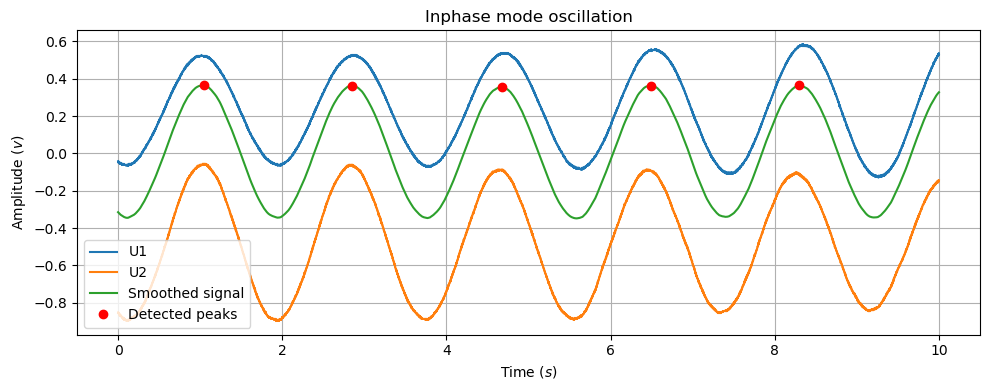

In [104]:
inphase_analyzer_3 = (
    CoupledPendulumAnalyzer('./data/inph3', mode='inphase')
    .load_data()
    .combine_signals()
    .preprocess()
    .detect_peaks()
    .compute_period()
)

inphase_analyzer_3.report()
inphase_analyzer_3.plot()


<IPython.core.display.Latex object>

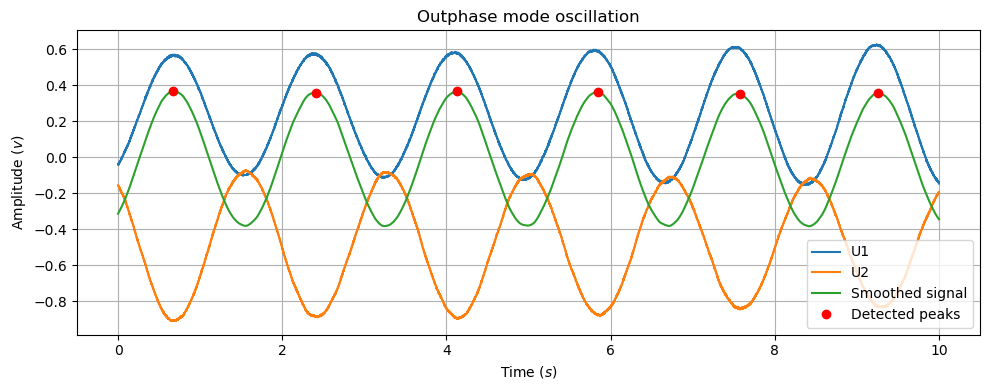

In [105]:
outphase_analyzer_3 = (
    CoupledPendulumAnalyzer('./data/outph3', mode='outphase')
    .load_data()
    .combine_signals()
    .preprocess()
    .detect_peaks(min_time=0.2, prom_frac=0.2)
    .compute_period()
)

outphase_analyzer_3.report()
outphase_analyzer_3.plot()

[Beat mode] Envelope weak — T_s estimated from autocorrelation.


<IPython.core.display.Latex object>

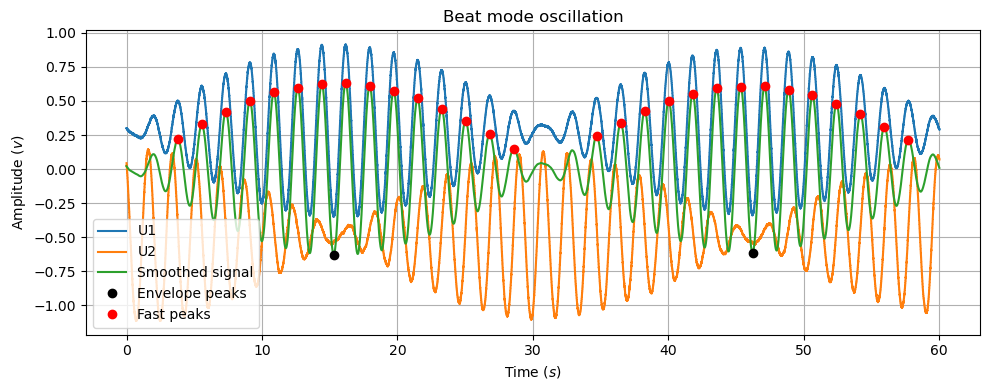

In [106]:
beat_analyzer_3 = (
    CoupledPendulumAnalyzer('./data/beat3', mode='beat')
    .load_data()
    .combine_signals()
    .preprocess()
    .detect_peaks(min_time=0.2, prom_frac=0.2)
    .compute_beat_periods()
)

beat_analyzer_3.report()
beat_analyzer_3.plot()


In [107]:
# Task 2: theoretical beat periods
T1, uT1 = inphase_analyzer_3.T_stats['median'], inphase_analyzer_3.T_stats['u_T']
T2, uT2 = outphase_analyzer_3.T_stats['median'], outphase_analyzer_3.T_stats['u_T']
beat_theory = compute_theoretical_beat(T1, uT1, T2, uT2)
T, Ts = beat_analyzer_3.beat_stats['T_fast'], beat_analyzer_3.beat_stats['T_env']
uT, uTs = beat_analyzer_3.beat_stats['u_T_fast'], beat_analyzer_3.beat_stats['u_T_env']
# Task 3: coupling coefficient
coupling = compute_degree_of_coupling(T1, uT1, T2, uT2, T, Ts, uT, uTs)

display(Latex(
f"$T'_{{theory}} = ({beat_theory['T_theory']:.3f} \\pm {beat_theory['u_T_theory']:.3f})~\\text{{s}}$ \\\n" +
f"$T'_S = ({beat_theory['TS_theory']:.3f} \\pm {beat_theory['u_TS_theory']:.3f})~\\text{{s}}$ \\\n" +
f"$k_1 = ({coupling['k_1']:.4f} \\pm {coupling['u_k']:.4f})$ \\\n"+
f"$k_2 = ({coupling['k_2']:.4f}\\pm {coupling['u_k_2']:.4f})$"
))


<IPython.core.display.Latex object>

In Position 3, we see that both the measured and calculated beat oscillation periods are within the uncertainties of each other, and thus can be said to be equivalent to each other. However, the beat periods themselves have a moderate divergence from each other. For the coupling constant, we see that $k_1$ and $k_2$ are relatively close to each other.

## For position 4

<IPython.core.display.Latex object>

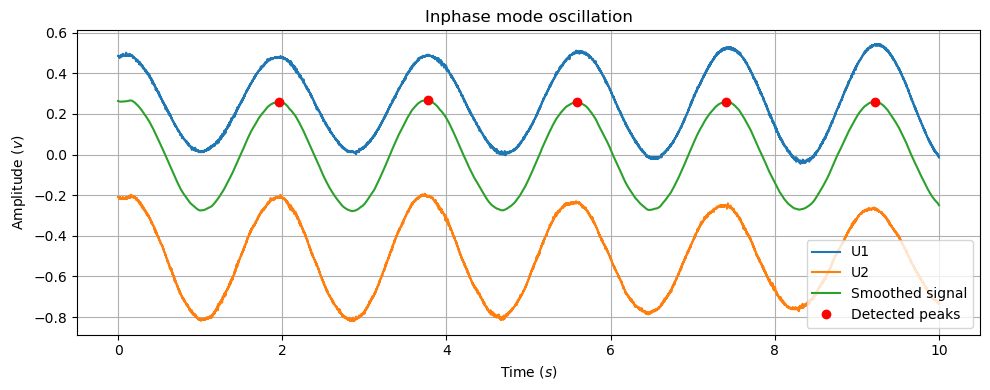

In [108]:
inphase_analyzer_4 = (
    CoupledPendulumAnalyzer('./data/inph4', mode='inphase')
    .load_data()
    .combine_signals()
    .preprocess()
    .detect_peaks(min_time=0.2, prom_frac=0.2)
    .compute_period()
)

inphase_analyzer_4.report()
inphase_analyzer_4.plot()

<IPython.core.display.Latex object>

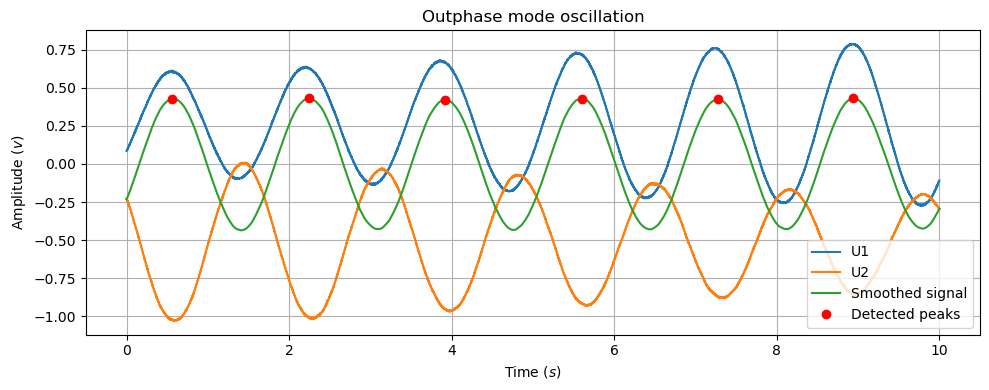

In [109]:
outphase_analyzer_4 = (
    CoupledPendulumAnalyzer('./data/outph4', mode='outphase')
    .load_data()
    .combine_signals()
    .preprocess()
    .detect_peaks(min_time=0.2, prom_frac=0.2)
    .compute_period()
)

outphase_analyzer_4.report()
outphase_analyzer_4.plot()

[Beat mode] Envelope weak — T_s estimated from autocorrelation.


<IPython.core.display.Latex object>

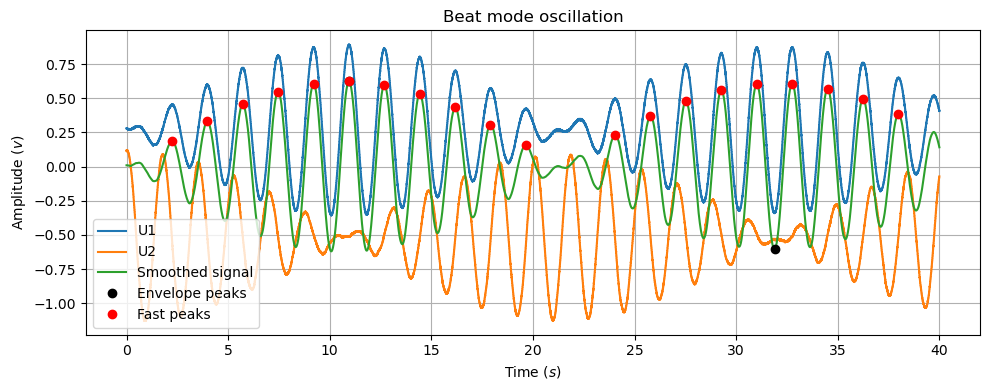

In [110]:
beat_analyzer_4 = (
    CoupledPendulumAnalyzer('./data/beat4', mode='beat')
    .load_data()
    .combine_signals()
    .preprocess()
    .detect_peaks(min_time=0.2, prom_frac=0.2)
    .compute_beat_periods()
)

beat_analyzer_4.report()
beat_analyzer_4.plot()

In [111]:
# Task 2: theoretical beat periods
T1, uT1 = inphase_analyzer_4.T_stats['median'], inphase_analyzer_4.T_stats['u_T']
T2, uT2 = outphase_analyzer_4.T_stats['median'], outphase_analyzer_4.T_stats['u_T']
T, Ts = beat_analyzer_4.beat_stats['T_fast'], beat_analyzer_4.beat_stats['T_env']
beat_theory = compute_theoretical_beat(T1, uT1, T2, uT2)

# Task 3: coupling coefficient
coupling = compute_degree_of_coupling(T1, uT1, T2, uT2, T, Ts, uT, uTs)

display(Latex(
f"$T'_{{theory}} = ({beat_theory['T_theory']:.3f} \\pm {beat_theory['u_T_theory']:.3f})~\\text{{s}}$ \\\n" +
f"$T'_S = ({beat_theory['TS_theory']:.3f} \\pm {beat_theory['u_TS_theory']:.3f})~\\text{{s}}$ \\\n" +
f"$k_1 = ({coupling['k_1']:.4f} \\pm {coupling['u_k']:.4f})$ \\\n"+
f"$k_2 = ({coupling['k_2']:.4f}\\pm {coupling['u_k_2']:.4f})$"
))

<IPython.core.display.Latex object>

In Position 4, we see again that both the measured and calculated beat oscillation periods are within the uncertainties of each other, and thus can be said to be equivalent to each other. However, the beat periods themselves have a larger divergence from each other. For the coupling constant, we see that $k_1$ and $k_2$ have a moderate amount of divergence.

## For position 5

<IPython.core.display.Latex object>

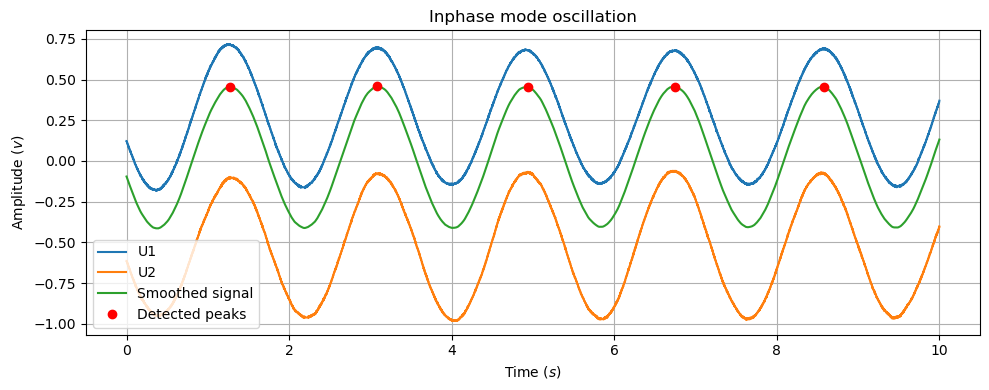

In [112]:
inphase_analyzer_5 = (
    CoupledPendulumAnalyzer('./data/inph5', mode='inphase')
    .load_data()
    .combine_signals()
    .preprocess()
    .detect_peaks(min_time=0.2, prom_frac=0.2)
    .compute_period()
)

inphase_analyzer_5.report()
inphase_analyzer_5.plot()

<IPython.core.display.Latex object>

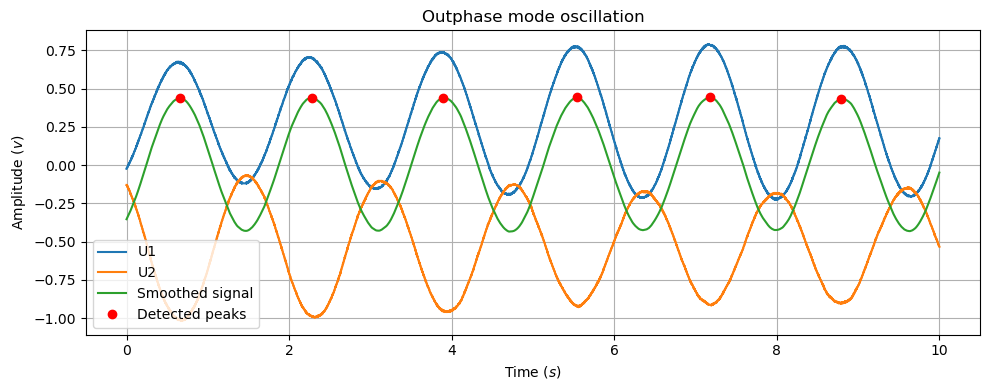

In [113]:
outphase_analyzer_5 = (
    CoupledPendulumAnalyzer('./data/outph5', mode='outphase')
    .load_data()
    .combine_signals()
    .preprocess()
    .detect_peaks(min_time=0.2, prom_frac=0.2)
    .compute_period()
)

outphase_analyzer_5.report()
outphase_analyzer_5.plot()

[Beat mode] Envelope weak — T_s estimated from autocorrelation.


<IPython.core.display.Latex object>

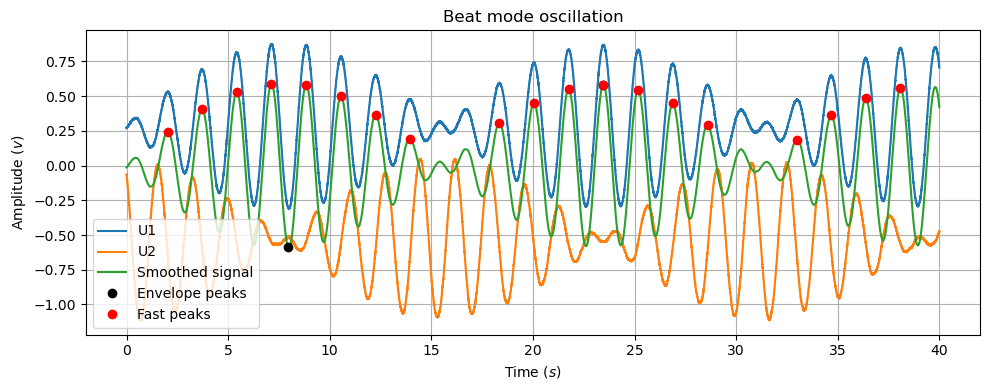

In [114]:
beat_analyzer_5 = (
    CoupledPendulumAnalyzer('./data/beat5', mode='beat')
    .load_data()
    .combine_signals()
    .preprocess()
    .detect_peaks(min_time=0.2, prom_frac=0.2)
    .compute_beat_periods()
)

beat_analyzer_5.report()
beat_analyzer_5.plot()

In [115]:
# Task 2: theoretical beat periods
T1, uT1 = inphase_analyzer_5.T_stats['median'], inphase_analyzer_5.T_stats['u_T']
T2, uT2 = outphase_analyzer_5.T_stats['median'], outphase_analyzer_5.T_stats['u_T']
T, Ts = beat_analyzer_5.beat_stats['T_fast'], beat_analyzer_4.beat_stats['T_env']
beat_theory = compute_theoretical_beat(T1, uT1, T2, uT2)

# Task 3: coupling coefficient
coupling = compute_degree_of_coupling(T1, uT1, T2, uT2, T, Ts, uT, uTs)

display(Latex(
f"$T'_{{theory}} = ({beat_theory['T_theory']:.3f} \\pm {beat_theory['u_T_theory']:.3f})~\\text{{s}}$ \\\n" +
f"$T'_S = ({beat_theory['TS_theory']:.3f} \\pm {beat_theory['u_TS_theory']:.3f})~\\text{{s}}$ \\\n" +
f"$k_1 = ({coupling['k_1']:.4f} \\pm {coupling['u_k']:.4f})$ \\\n"+
f"$k_2 = ({coupling['k_2']:.4f}\\pm {coupling['u_k_2']:.4f})$"
))

<IPython.core.display.Latex object>

Finally, in Position 5, we see that this time that the measured and calculated beat oscillation periods are again within each other's uncertainties. Now, the beat periods themselves have a significant divergence from each other. For the coupling constant, we see that $k_1$ and $k_2$ have a significant amount of divergence.


Now, we move to Task 4 where we first determine the spring constant of the spring that was used. As aforementioned, various masses were hung from the spring and the displacements measured.

In [116]:
# Spring constant from hanging-mass calibration (Hooke’s law)
def spring_constant_from_masses(m_g, h_cm, g=9.81):
    """
    Compute spring constant c from hanging-mass experiment.

    Parameters
    ----------
    m_g : list or array
        Masses in grams
    h_cm : list or array
        Measured spring lengths in cm
    g : float
        Gravitational acceleration (m/s^2)

    Returns
    -------
    dict with c [N/m] and u_c [N/m]
    """
    m = np.array(m_g) / 1000     # kg
    h = np.array(h_cm) / 100     # m

    L0 = np.max(h)               # assume smallest load = rest length
    dx = L0 - h
    F = m * g

    slope, intercept, r, p, stderr = linregress(dx, F)
    c, u_c = slope, stderr

    display(Latex(
    f"Hooke's-law calibration:  $F = c\\,\\Delta x$ \\\n" +
    f"$c = ({c:.2f} \\pm {u_c:.2f})\\,\\text{{N/m}}$ \\\n" +
    f"$R^2 = {r**2:.4f}$"
    ))
    

# Spring constant from coupled-pendulum periods (Task 4)
def spring_constant_from_periods(lF, T1, T2, m=1.3295, sA=0.747, g=9.81):
    """
    Determine c from slope of T1^2/T2^2 = 1 + (2c/D) * lF^2
    for Pendulum VII & VIII.

    lF : array-like [m]
    T1 : in-phase periods [s]
    T2 : out-of-phase periods [s]
    """
    D = m * g * sA                   # torque constant
    x = np.array(lF)**2
    y = (np.array(T1)**2) / (np.array(T2)**2)

    slope, intercept, r, p, stderr = linregress(x, y)
    c = slope * D / 2
    u_c = stderr * D / 2

    display(Latex(
        f"Linear relation:  $\\dfrac{{T_1^2}}{{T_2^2}} = 1 + \\dfrac{{2c}}{{D}}\\,l_F^2$ \\\n" +
        f"$D = m g s_A = {D:.3f} N m$ \\\n" +
        f"$\\Rightarrow\\; c = ({c:.3f} \\pm {u_c:.3f})N/m$ \\\n" +
        f"$R^2 = {r**2:.4f}$"
    ))



In [117]:
# Hanging-mass calibration ---
masses = [10,20,30,40,50,60,70]    # g
heights = [66.5,60,58,54.5,50.5,46.8,42.9]  # cm
spring_constant_from_masses(masses, heights)

<IPython.core.display.Latex object>

For Task 4, we see that the data for the coupling spring measured with different masses has good correlation with the expected linear relationship yielding a value for the spring constant.

Now, using the relationship derived earlier, we explore the influence of the position of the coupling spring position on the ratio of $T_1$ and $T_2$, and we use this to derive a theoretical value for the spring constant.

In [118]:
# Coupled pendulums (Task 4) ---
lF = [0.482, 0.582, 0.682]  # m
T1 = [inphase_analyzer_3.T_stats['median'], inphase_analyzer_4.T_stats['median'], inphase_analyzer_5.T_stats['median']]
T2 = [outphase_analyzer_3.T_stats['median'], outphase_analyzer_4.T_stats['median'], outphase_analyzer_5.T_stats['median']]
spring_constant_from_periods(lF, T1, T2)

<IPython.core.display.Latex object>

We see that we obtain a value for the coupling spring constant with high confidence, however as can be seen there is a moderate divergence between the experimentally measured value and the theoretically derived one.

# Analysis

## Task 1

The measured values of the in-phase ($T_1$) and out-of-phase ($T_2$) oscillations for the three coupling spring positions show a consistent physical trend. As the coupling spring is moved farther from the rotation axis (from Position 3 to 5), the coupling strength increases because the lever arm $l_F$ grows, increasing the torque transmitted by the spring. Consequently, the difference between $T_1$ and $T_2$ becomes larger, and the beat period $T_S$ decreases, as predicted theoretically.

The measured in-phase oscillation periods ($T_1$) are slightly longer than the out-of-phase periods ($T_2$), in agreement with the model, since the coupling spring adds restoring torque in the out-of-phase configuration but not in the in-phase case. For all spring positions, the beat oscillation period $T$ extracted from the data matches the expected value obtained from the equation within the experimental uncertainty, confirming the consistency of the measured frequencies.

However, the beat periods $T_S$ determined from the envelope were more difficult to measure precisely. In most datasets, the envelope peaks were weak and had to be estimated from the autocorrelation of the amplitude signal. This introduced additional uncertainty, especially when the beat frequency was low (Position~3). Since only a few beat cycles were captured within the 60~s acquisition window, even small timing errors in peak detection could lead to significant percentage errors in $T_S$.

## Task 2

The calculated beat oscillation periods $T'$ obtained from the measured $T_1$ and $T_2$ values agree reasonably well with the experimental measurements. For all three spring positions, $T'$ is within the uncertainty range of the measured beat oscillation period $T$, demonstrating that the theoretical relationship is well satisfied in practice.

In contrast, the calculated and measured beat periods $T_S$ show progressively larger divergences as the spring position moves outward. For Position~3, the divergence is moderate, but for Positions~4 and~5 the measured $T_S$ values are substantially larger than theoretical predictions. This discrepancy likely arises from the difficulty in identifying envelope maxima when the beat modulation is weak or irregular. 

## Task 3

The degree of coupling $k$ was computed both from the measured values of $T_1$ and $T_2$ ($k_1$) and from the beat parameters ($k_2$). For all spring positions, $k$ increases with $l_F$, consistent with the theoretical expectation that $k \propto D^*/D$ and that $D^*$ grows with $l_F^2$.

At Position~3, the two determinations $k_1 = 0.0505 \pm 0.0056$ and $k_2 = 0.0402 \pm 0.0035$ agree well within their uncertainties. As the coupling becomes stronger, however, the values diverge: at Position~5 the difference becomes significant ($0.1116$ vs.\ $0.0448$). This trend can be explained primarily through two reasons. Firstly, the theoretical derivation assumes weak coupling. However as $l_F$ increases, that relation no longer holds true. Secondly, the values for the beat period have a much higher uncertainty due to the limited data acquisition window, which affects the value of $k_2$.

## Task 4

Using the equation, the dependence of the oscillation-period ratio on the square of the coupling-arm length $l_F^2$ was tested for several spring positions. The resulting linear regression yielded a value for the spring constant in excellent correlation with the theoretical linear model. The value is somewhat higher than the experimentally measured spring constant obtained from the hanging-mass calibration, which too had excellent correlation with the theoretical linear model.

# Future Expansions

For future experiments on the coupled pendulum, we could improve our experiment by:

1. More precise initialization of the system, through mechanical means allowing greater precision in the initial amplitude.

2. Considering cases other than weak coupling, allowing for potentially a more accurate $k_2$ value.

3. Longer data acquisition periods, allowing for greater precision and insight into the beat period behavior.




